# Question B3 (10 marks)

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [3]:
!pip install captum

In [4]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

1.First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [6]:
df = pd.read_csv('hdb_price_prediction.csv')

# Training Data Set: Year 2019 and before
df_train = df[df['year'] <= 2019].copy()
# Validation Data Set: Year 2020
df_val = df[df['year'] == 2020].copy()
# Testing Data Set: Year 2021
df_test = df[df['year'] == 2021].copy()

# Dropping all Categorical Features
categorical_features = ['month','town','flat_model_type','storey_range', 'full_address','nearest_stn','year']

df_train.drop(columns = categorical_features, inplace=True)
df_val.drop(columns = categorical_features, inplace=True)
df_test.drop(columns = categorical_features, inplace=True)

print("Training Data:", df_train.shape)
print("Validation Data:", df_val.shape)
print("Testing Data:", df_test.shape) 

Training Data: (64057, 7)
Validation Data: (23313, 7)
Testing Data: (29057, 7)


In [7]:
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]

X_val = df_val.iloc[:,:-1]
y_val = df_val.iloc[:,-1]

X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

2.Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [9]:
class FeedForwardNN(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.lin1 = nn.Linear(no_features, no_hidden)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(no_hidden, no_hidden)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(no_hidden, no_hidden)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(no_hidden, no_labels)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))


# Define the hyperparameters
no_features = X_train.shape[1] 
no_hidden = 5                  
no_labels = 1                  
batch_size = 50
num_epochs = 200
learning_rate = 0.001

model = FeedForwardNN(no_features,no_hidden,no_labels)
model.train()

FeedForwardNN(
  (lin1): Linear(in_features=6, out_features=5, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=5, out_features=5, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=5, out_features=5, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
# Tensorizing inputs and creating batches
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).view(-1, 1).float()

X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

In [11]:
# Defining the loss function
criterion = nn.MSELoss(reduction='sum')

In [12]:
def train(model_inp, num_epochs = num_epochs):
   
    # Define Adam optimizer with lr 0.001
    optimizer = torch.optim.Adam(model_inp.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            
            # defining loss
            loss = criterion(outputs, labels)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # computing gradients
            loss.backward()
            
            # accumulating running loss
            running_loss += loss.item()
            
            # updated weights based on computed gradients
            optimizer.step()
            
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

In [13]:
# Training Model
train(model, num_epochs)

Epoch [1]/[200] running accumulative loss across all batches: 5864230265332736.000
Epoch [21]/[200] running accumulative loss across all batches: 343388038875904.000
Epoch [41]/[200] running accumulative loss across all batches: 340179809420032.000
Epoch [61]/[200] running accumulative loss across all batches: 338695912795904.000
Epoch [81]/[200] running accumulative loss across all batches: 337736289613568.000
Epoch [101]/[200] running accumulative loss across all batches: 337154708914688.000
Epoch [121]/[200] running accumulative loss across all batches: 336576435675520.000
Epoch [141]/[200] running accumulative loss across all batches: 336216780937984.000
Epoch [161]/[200] running accumulative loss across all batches: 335872431893504.000
Epoch [181]/[200] running accumulative loss across all batches: 335693959937792.000


In [14]:
# Evaluating Model
from sklearn.metrics import mean_squared_error

model.eval()
outputs = model(X_test_tensor)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test_tensor.detach().numpy()))

print('Model Err (Mean Squared Error): ', err)

Model Err (Mean Squared Error):  100674.69


In [15]:
# Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation from Captum library

saliency = Saliency(model)
input_x_gradient = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

saliency_attr_test = saliency.attribute(X_test_tensor)
input_x_gradient_attr_test = input_x_gradient.attribute(X_test_tensor)
ig_attr_test = ig.attribute(X_test_tensor, n_steps=50)
gs_attr_test = gs.attribute(X_test_tensor, X_train_tensor)
fa_attr_test = fa.attribute(X_test_tensor)

C:\Users\Admin\anaconda3\envs\myenv_py38\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [16]:
# create list of features
feature_names = X_test.columns.tolist()
feature_names

['dist_to_nearest_stn',
 'dist_to_dhoby',
 'degree_centrality',
 'eigenvector_centrality',
 'remaining_lease_years',
 'floor_area_sqm']

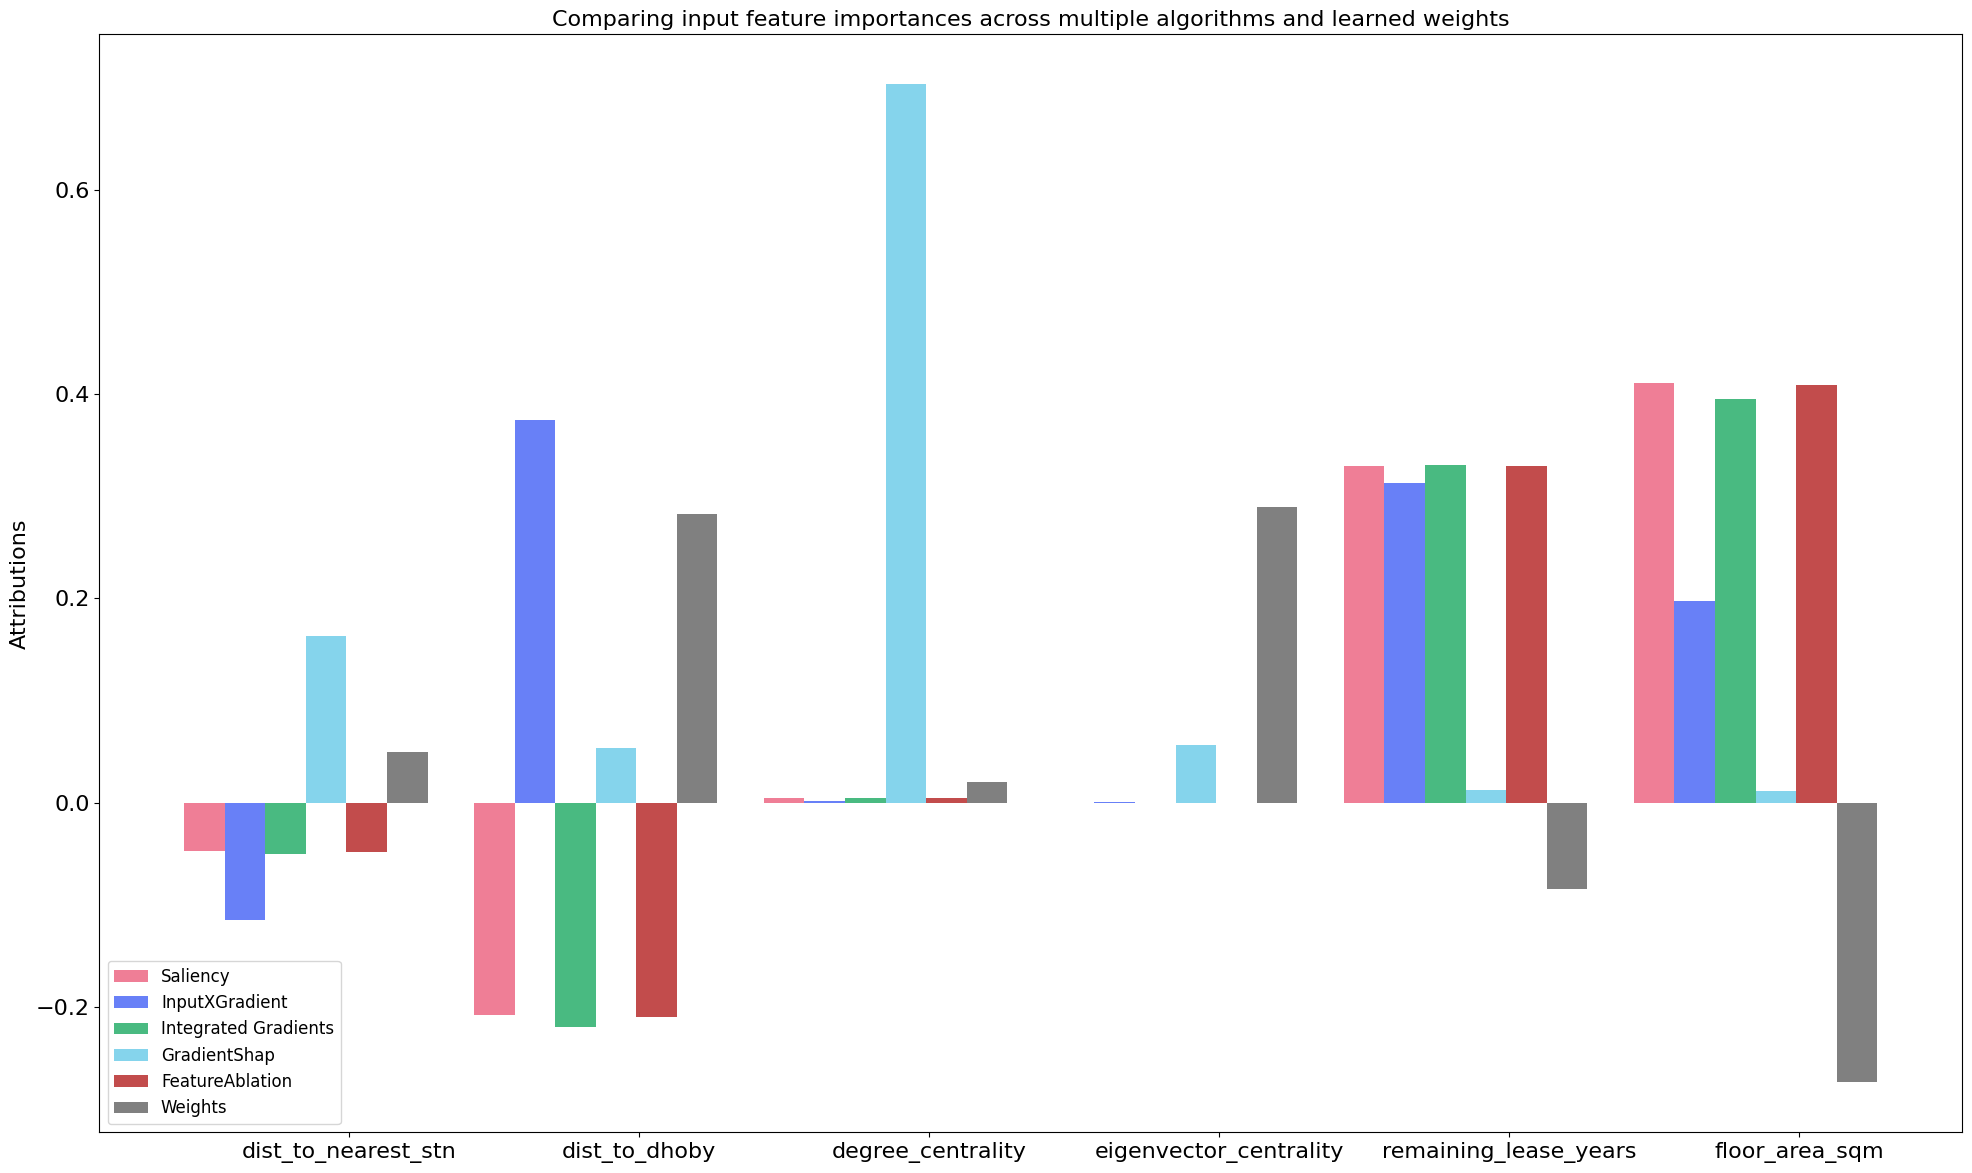

In [47]:
# Prepare attributions for visualization
import matplotlib.pyplot as plt

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

saliency_attr_test_sum = saliency_attr_test.detach().numpy().sum(0)
saliency_attr_test_norm_sum = saliency_attr_test_sum / np.linalg.norm(saliency_attr_test_sum, ord=1)

input_x_gradient_attr_test_sum = input_x_gradient_attr_test.detach().numpy().sum(0)
input_x_gradient_attr_test_norm_sum = input_x_gradient_attr_test_sum / np.linalg.norm(input_x_gradient_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Saliency', 'InputXGradient', 'Integrated Gradients', 'GradientShap', 'FeatureAblation',  'Weights']

plt.figure(figsize=(20, 12))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 2 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 3 * width, saliency_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 4 * width, input_x_gradient_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

3.Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [49]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the hyperparameters
no_features = X_train.shape[1] 
no_hidden = 5                  
no_labels = 1                  

scaled_model = FeedForwardNN(no_features,no_hidden,no_labels)
scaled_model.train()

FeedForwardNN(
  (lin1): Linear(in_features=6, out_features=5, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=5, out_features=5, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=5, out_features=5, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=5, out_features=1, bias=True)
)

In [51]:
# Tensorizing inputs
X_train_scaled_tensor = torch.tensor(X_train_scaled).float()
X_test_scaled_tensor = torch.tensor(X_test_scaled).float()

In [53]:
# Training Scaled Model
train(scaled_model, num_epochs)

Epoch [1]/[200] running accumulative loss across all batches: 3561527573196800.000
Epoch [21]/[200] running accumulative loss across all batches: 343003592868608.000
Epoch [41]/[200] running accumulative loss across all batches: 292633644759040.000
Epoch [61]/[200] running accumulative loss across all batches: 264789558713344.000
Epoch [81]/[200] running accumulative loss across all batches: 254759233767680.000
Epoch [101]/[200] running accumulative loss across all batches: 249925029443968.000
Epoch [121]/[200] running accumulative loss across all batches: 246121917318912.000
Epoch [141]/[200] running accumulative loss across all batches: 242873271659648.000
Epoch [161]/[200] running accumulative loss across all batches: 240254173019392.000
Epoch [181]/[200] running accumulative loss across all batches: 238342147905152.000


In [54]:
# Evaluation of Model and Error
scaled_model.eval()
outputs = model(X_test_scaled_tensor)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test_tensor.detach().numpy()))

print('Scaled Model Error (Mean Squared Error): ', err)

Scaled Model Error (Mean Squared Error):  512384.44


In [55]:
# Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation from Captum library

saliency = Saliency(scaled_model)
input_x_gradient = InputXGradient(scaled_model)
ig = IntegratedGradients(scaled_model)
gs = GradientShap(scaled_model)
fa = FeatureAblation(scaled_model)

saliency_attr_test = saliency.attribute(X_test_scaled_tensor)
input_x_gradient_attr_test = input_x_gradient.attribute(X_test_scaled_tensor)
ig_attr_test = ig.attribute(X_test_scaled_tensor, n_steps=50)
gs_attr_test = gs.attribute(X_test_scaled_tensor, X_train_tensor)
fa_attr_test = fa.attribute(X_test_scaled_tensor)

C:\Users\Admin\anaconda3\envs\myenv_py38\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


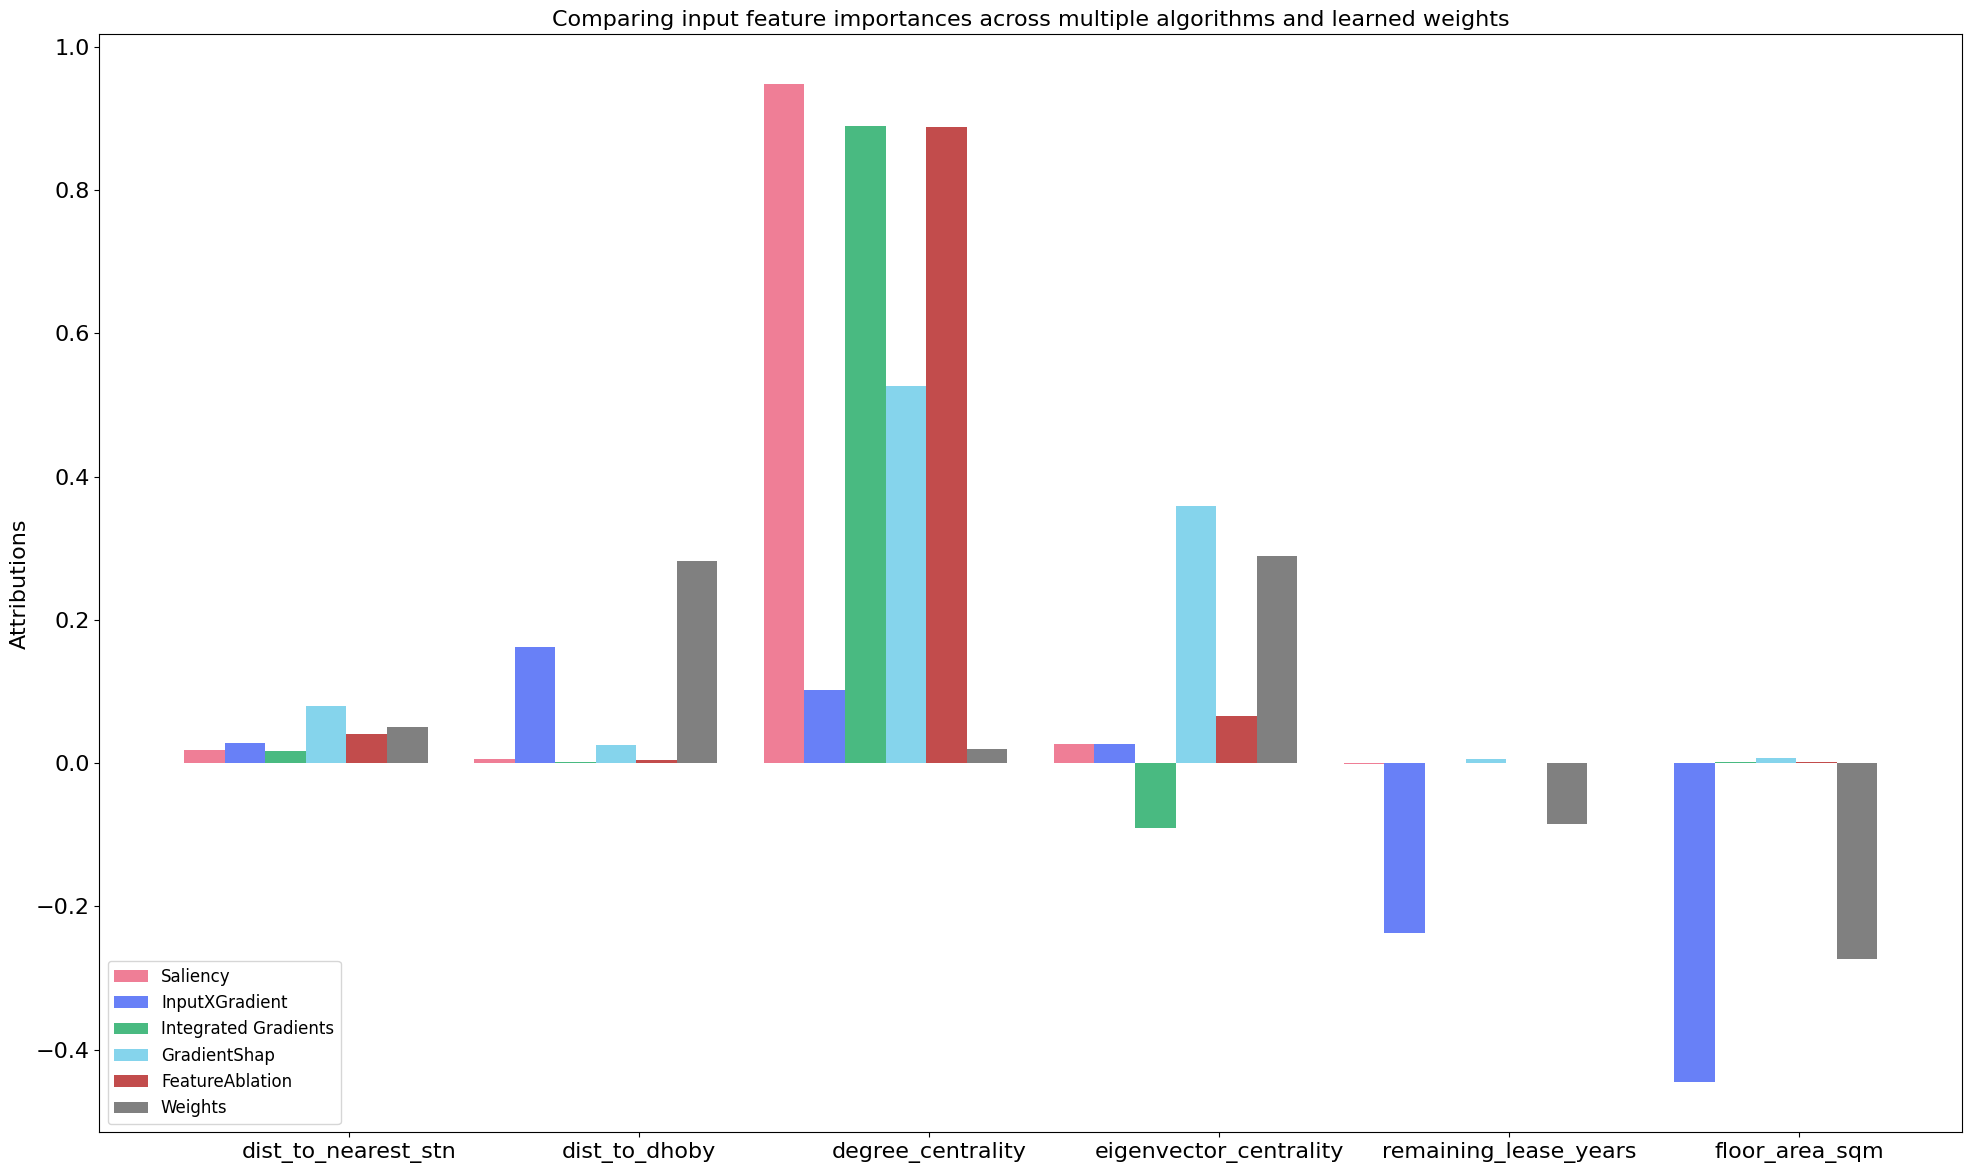

In [56]:
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

saliency_attr_test_sum = saliency_attr_test.detach().numpy().sum(0)
saliency_attr_test_norm_sum = saliency_attr_test_sum / np.linalg.norm(saliency_attr_test_sum, ord=1)

input_x_gradient_attr_test_sum = input_x_gradient_attr_test.detach().numpy().sum(0)
input_x_gradient_attr_test_norm_sum = input_x_gradient_attr_test_sum / np.linalg.norm(input_x_gradient_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Saliency', 'InputXGradient', 'Integrated Gradients', 'GradientShap', 'FeatureAblation',  'Weights']

plt.figure(figsize=(20, 12))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 2 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 3 * width, saliency_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 4 * width, input_x_gradient_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

State your observations with respect to GradientShap and explain why it has occurred. 
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)

Observations
1. Standard Scaler model has lower GradientShap values for features 'dist_to_nearest_stn', 'dist_to_dhoby' and 'degree_centrality' compared to non-scaled model.
2. Higher GradientShap value for feature 'eigenvector_centrality' in Standard Scaler model, compared to non-scaled model.
3. GradientShap values for features 'remaining_lease_years' and 'floor_area_sqm' remained near zero for both Standard Scaler grap

Explanation
-  Impact of standardization: StandardScaler transforms all features to have Mean = 0 and Standard deviation = 1
-  Default baseline behavior: GradientShap typically uses zero as the default baseline. In the non-scaled data, zero is often far from the feature's typical values. In standardized data, zero is exactly the mean of each feature, which means the mean of feature is considered the baseline for GradientShap.
-  GradientShap calculates feature importance by measuring how predictions change as features move from the baseline to actual values. When features are standardized, the zero baseline is now a "typical" value (the mean) rather than an extreme or unusual value. This reduces the "distance" features need to travel from baseline to actual values, often resulting in smaller attribution values.
-  The non-scaled results might overemphasize the importance of features with naturally larger scales or ranges.
The standardized results provide a more normalized view of feature importance, where the scale of the original features doesn't impact the attribution values.

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

4.Why did Saliency produce scores similar to IG?


Saliency and IG are both gradient-based attribution methods. Saliency calculates the gradient of output with respect to the input point, which measures how a change in each feature at the input point affects the output. IG calculates the integral of gradients along a path from a baseline to the input, and measures the cumulative impact of each feature's value change over a range of inputs. 
Although saliency and IG have slight differences, they produce similar scores as flat price prediction is a regression problem and many features have roughly linear relationships with price. This maintains gradient consistency between baseline and input.

5.Why did Input x Gradients give the same attribution scores as IG?


Input x Gradients and IG attributes feature importance to output prediction through calculating attribute score using gradients. Similar attribution scores are due to approximately linear models used in both methods and gradient consistency along the path from baseline to input.